# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [10]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [11]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [12]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [13]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [14]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-17 17:00:05--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.003s  

2025-05-17 17:00:06 (7.18 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-17 17:00:06--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [15]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

In [16]:
len(documents)



100

In [17]:
chunkSizes = []
for doc in documents:
    chunkSizes.append(len(doc.page_content))


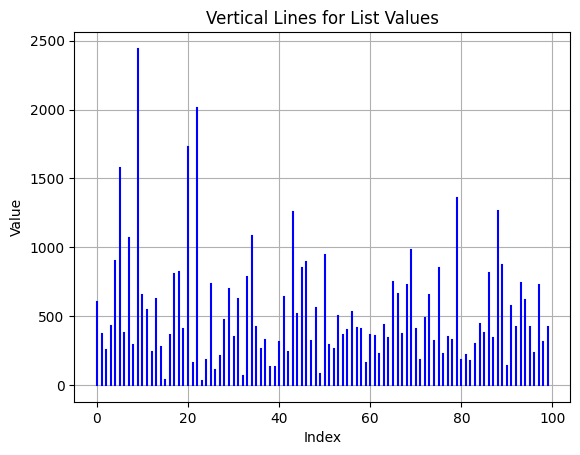

In [18]:
import matplotlib.pyplot as plt

# Example list of integers
data = chunkSizes

# Create x-axis values (indices of the list)
x = range(len(data))

# Plot vertical lines for each integer
for i, value in enumerate(data):
    plt.plot([i, i], [0, value], 'b-')  # 'b-' means blue line

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Vertical Lines for List Values')
plt.grid(True)

# Show the plot
plt.show()

Let's look at an example document to see if everything worked as expected!

In [19]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 14, 17, 0, 9, 504314)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [20]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

/Users/mwalker/development/TAMARKDesigns/AI-Maker-Space/cohort-6/AIE6-TMD/13_Advanced_Retrieval/.venv/lib/python3.12/site-packages/qdrant_client/http/models/models.py:758: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is empty, alternative syntax for `is_empty: \&quot;field_name\&quot;`",
/Users/mwalker/development/TAMARKDesigns/AI-Maker-Space/cohort-6/AIE6-TMD/13_Advanced_Retrieval/.venv/lib/python3.12/site-packages/qdrant_client/http/models/models.py:762: SyntaxWarning: invalid escape sequence '\&'
  description="Check that the field is null, alternative syntax for `is_null: \&quot;field_name\&quot;`",


## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [21]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [22]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [79]:
from langchain_openai import ChatOpenAI

#chat_model = ChatOpenAI(model_name="gpt-4.1-nano")

# Had to change the creation so we could synthesize the golden dataset via RAGAS later.
chat_model = ChatOpenAI(model="gpt-4.1-nano", temperature=0, max_tokens=1024)



### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [24]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [25]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. Many reviewers gave it high ratings, praised its action sequences, style, and Keanu Reeves' performance. For example, reviews with ratings of 9 or 10 praised the film as the best action movie of the year or a slick, violent, fun film. Even those with more moderate ratings acknowledged its stylish action and choreography. However, there were a few mixed or lower-rated opinions, but overall, the sentiment suggests that most people enjoyed the film."

In [26]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [27]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the story primarily revolves around John Wick, a retired hitman who is drawn back into a violent underworld of assassins and crime. The series begins with a simple yet intense plot: John Wick's beloved dog is killed and his car stolen by a young Russian punk, which leads him to seek revenge against those who wronged him. As the story progresses across subsequent films, Wick becomes entangled in complex criminal conflicts, adhering to a strict code of honor and facing off against formidable enemies, including mobsters and professional killers. The series is known for its stylish action sequences, gritty atmosphere, and exploration of a criminal underworld where John Wick navigates revenge, honor, and survival."

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [28]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [29]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [30]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people's opinions on John Wick vary. The first and second reviews are highly positive, praising the films for their action, style, and entertainment value, with ratings of 8 and 10 respectively. However, subsequent reviews are very negative, criticizing the third film for being dull, stereotypical, and overly violent, with a rating of only 1. \n\nOverall, it seems that many people liked the earlier John Wick movies, but opinions become more divided or negative with the later installments. Therefore, people did generally like John Wick, especially in the earlier films, but there are notable negative opinions as well."

In [31]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided reviews, there are no reviews with a rating of 10.'

In [32]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, the story generally revolves around a retired hitman named John Wick who is drawn back into a violent world of assassins and criminal organizations. The first film, John Wick 1, depicts how Wick, mourning the loss of his wife and trying to leave his violent past behind, is compelled to return to violence after a group of criminals steal his car and kill his dog, a gift from his deceased wife. This sets off a relentless chain of revenge and action as Wick seeks to exact justice and confront his enemies.\n\nSubsequent movies, such as John Wick 2, continue to follow Wick's struggles with larger assassin communities and elaborate assassin rules, showcasing intense action, detailed choreography, and the saga of his ongoing battles with various foes. The storyline involves Wick's conflicts with powerful crime factions, personal vendettas, and his attempts to find peace while constantly being pulled back into violence.\n\nOverall, the series highlights Wick’s skills 

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [33]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [34]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [35]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The reviews are highly positive, with ratings of 9 and 10 out of 10, and praise for its action sequences, style, and Keanu Reeves' performance. Only one review was somewhat negative with a rating of 5, but the majority of reviews indicate that viewers liked the film."

In [36]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [https://.../review/rw4854296/?ref_=tt_urv](https://.../review/rw4854296/?ref_=tt_urv)  \n2. [https://.../review/rw4860412/?ref_=tt_urv](https://.../review/rw4860412/?ref_=tt_urv)  \n\n(Note: The full URLs are provided in the context as relative links, but these are the identifiers for the reviews with a rating of 10.)'

In [37]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick, played by Keanu Reeves, is a retired hitman who seeks vengeance after a series of violent events. In the first film, he comes out of retirement after Russian gangsters kill his dog, a gift from his deceased wife, which triggers a relentless quest for retribution. The story involves him taking on various criminals and mobsters, leading to intense action and combat. \n\nIn the second film, John Wick returns home after resolving issues with the Russian mafia, but is soon approached by Santino D'Antonio, who shows him a marker and asks for his help. Wick refuses, leading to his house being blown up. Santino then asks him to kill his sister in Rome so he can take a seat at the High Table of the criminal organization. After completing the assassination, Wick is betrayed, and a contract is placed on him, making him a target for bounty hunters. He then fights to survive while seeking to confront Santino and resolve the threats against him.\n\nOverall, the f

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [38]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [39]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [40]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the provided reviews, people generally liked John Wick. Many reviews gave high ratings and positive comments about the action sequences, style, and entertainment value of the films. While some individuals expressed less enthusiasm or found the plot lacking, the overall sentiment suggests that John Wick was well-received and appreciated by most viewers.'

In [41]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. The URLs to those reviews are:\n- /review/rw4854296/?ref_=tt_urv\n- /review/rw4860412/?ref_=tt_urv'

In [42]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick film series, the story centers around John Wick, a retired hitman who is drawn back into a violent world of assassins after personal tragedy strikes him. The first film begins with John seeking vengeance after a gangsters kills his dog and steals his car, which leads him to unleash a relentless and carefully orchestrated wave of destruction against those who have wronged him. Throughout the series, he confronts various criminal organizations, debts, and rules of the assassin underworld, often fighting to protect his own life and maintain his reputation as a deadly and skilled assassin. The films depict his journey of revenge, survival, and navigating a complex, dangerous world filled with violence and high-stakes conflicts.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [43]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [44]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_4997/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [45]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [46]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [47]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [48]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people\'s opinions on John Wick vary. Some reviewers, like MrHeraclius, highly recommend the series and praise it positively. However, others, such as solidabs, gave a very negative review of John Wick 4, describing it as a "horrible movie" and expressing disappointment with the plot and fight scenes. \n\nTherefore, people did not generally have a uniform opinion; some liked the series, while others did not.'

In [49]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [50]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, John Wick is a retired assassin who comes out of retirement due to personal losses and circumstances that compel him to re-engage in violence. The first film centers on his quest for vengeance after his dog is killed and his car is stolen, leading him to confront gangsters and assassins to settle old scores. The second movie continues his stories of action and revenge, involving helping a former associate take over the Assassin's Guild, which takes him on dangerous missions across Italy, Canada, and Manhattan, resulting in a lot of carnage and confrontations with numerous assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [51]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [52]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [53]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided in the context, people generally liked John Wick. Many reviews are highly positive, praising its stylish action sequences, choreography, and Keanu Reeves' performance. Some reviews rated it as high as 10/10, indicating strong approval. However, there are also some mixed and negative opinions, particularly about later installments, criticizing their plot and violence. Overall, the general perception among reviewers seems to be that people enjoyed John Wick, especially the first film and its high-quality action."

In [54]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [55]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, the story revolves around John Wick, a retired hitman who is pulled back into a violent world of assassins. The first film shows how Wick seeks revenge after gangsters kill his dog and steal his car, leading him to unleash a deadly and meticulously choreographed assault against those responsible. Subsequent films continue to explore themes of revenge, consequences, and loyalty within the criminal underworld, with Wick confronting old enemies, helping or fighting powerful crime figures, and dealing with the rules and rivalries of the assassin society. The series is known for its intense action sequences, stylish violence, and the character's quest for peace and retribution amid a vast and deadly underground universe."

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [56]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [57]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [58]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [59]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [60]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [61]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [62]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. The reviews are mostly positive, with high ratings and praise for its action, style, and entertainment value.'

In [63]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review that has a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [64]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie John Wick, the story centers around a retired assassin named John Wick (played by Keanu Reeves) who seeks revenge after a violent assault on his home. The assault is carried out by a group of thugs led by the son of a Russian gangster John used to work for. They break into his house, beat him up, kill his dog, and steal his car, not knowing who he really is. The loss of his beloved dog and his stolen car ignite his desire for vengeance. As the story unfolds, John Wick unleashes a relentless and highly skilled pursuit of those who wronged him, becoming embroiled in a violent conflict with the Russian mafia and other enemies, leading to numerous action-packed confrontations.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Retriever Evaluation

### Generating the Golden Dataset
The following code will use RAGAS to generate 10 questions from the base knowledge (loaded earlier in this notebook). 

In [65]:

# Retrieve the LangChain API key, which will be used to collect latency and cost information.

import getpass
import os

os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangChain API key: ")


In [86]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator.from_langchain(
    llm=chat_model,
    embedding_model=embeddings
)

testset = generator.generate_with_langchain_docs(
    documents=documents,
    testset_size=10,
    with_debugging_logs=False
)

# print the testset (Question and Grounded Truth)
for sample in testset.samples:
    print("Q:", sample.eval_sample.user_input)
    print("GT:", sample.eval_sample.reference)
    print("—" * 60)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node b271ab0c-52fe-4f5c-a58f-26aef0a59d17 does not have a summary. Skipping filtering.
Node 1418cd58-0982-4fc8-b5b1-d6b0991844af does not have a summary. Skipping filtering.
Node 8b2b361b-763e-457d-be45-316c2580558d does not have a summary. Skipping filtering.
Node 66fb4fd1-29bd-4837-bab5-fd2068a6f7ec does not have a summary. Skipping filtering.
Node 70b4c568-e627-48d4-87ac-f318a7145ee5 does not have a summary. Skipping filtering.
Node 5a596d89-7b05-4a80-8c12-e61293c23e47 does not have a summary. Skipping filtering.
Node 99b31aa9-1a46-4c64-9bde-a8766c425a18 does not have a summary. Skipping filtering.
Node c58c8c68-34cd-4083-b6b4-e24e120ee6b4 does not have a summary. Skipping filtering.
Node 0e03bf38-fc88-4f45-b58c-cc7515b11dac does not have a summary. Skipping filtering.
Node 3d0ad718-4ac9-436c-b461-0c06b12a923d does not have a summary. Skipping filtering.
Node 7386aa86-751a-4a91-a2cb-9c0117911dbf does not have a summary. Skipping filtering.
Node 47d2bf68-5f96-4ae7-b4fb-4ac773927866 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/220 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

Q: So like Keanu Reeves is in that movie John Wick right and he does all those crazy fight scenes and stuff but what makes him like such a good action star in that movie and why do people like him so much in action movies?
GT: Keanu Reeves is the star of John Wick, which is praised for its awesome action, stylish stunts, and kinetic chaos. The movie's simple premise and Reeves' relatable hero character contribute to its success, making him a well-loved action star.
————————————————————————————————————————————————————————————
Q: So like why is John Wick so popular and stuff and why did everyone like it so much and what makes it different from other action movies I mean I just wanna know why people keep talking about John Wick and what makes it so special compared to all the other action movies I’ve seen or heard about?
GT: The context states that after three previous films that are apparently loved by everyone else, the person decided to check out "John Wick". The review mentions that t

In [88]:
# Save the testset for potential reuse
import json

with open("testset.json", "w") as f:
    json.dump([s.model_dump() for s in testset.samples], f, indent=2)


In [ ]:
### YOUR CODE HERE